<a href="https://colab.research.google.com/github/jarek-pawlowski/machine-learning-applications/blob/main/simple_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-attention and Transformers
- In this laboratory we are going to build a simple transformer model (strictly spealking, it's encoder part) ant test it to simple function transformation problem.
- We will follow the implementation details of the transformer from the famous paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).
- Transformer models are already implemented in PyTorch ([Transformer class](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) but in order to get intuitions about this NN architecture we will try to build one from scratch.


## Prerequisites
Before we start we need to load libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from functools import partial
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Building  the model
The Transformer model consists following structure blocks that have to be defined step by step:
1. Scaled Dot-Product Attention (self-attention)
2. Multi-Head Attention 
3. Simple MLP block
4. Encoder (Decoder)
5. Positional Encoding mechanism

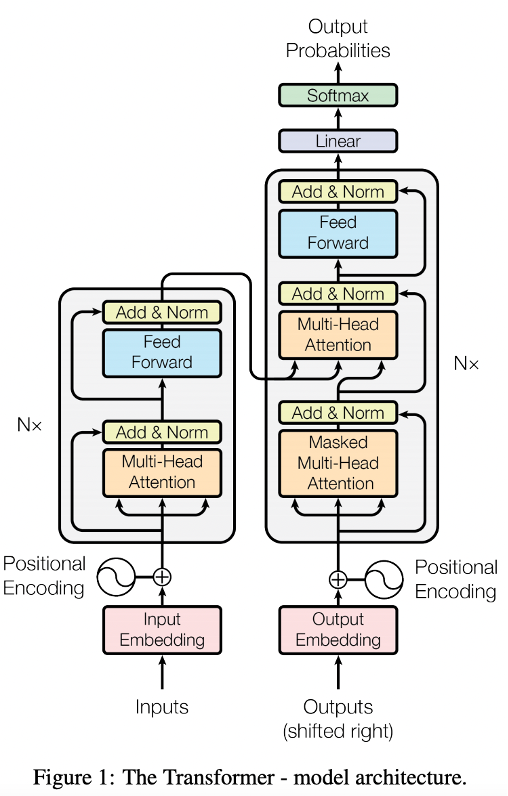


### Scaled Dot-Product Attention
Let's start bulding the transformer from defining **Scaled Dot-Product Attention** block:

$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$,

with queries vector $Q\in\mathbb{R}^{T\times d_k}$, keys vector $K\in\mathbb{R}^{T\times d_k}$, and values vector $V\in\mathbb{R}^{T\times d_v}$, 

where $T$ is the input sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values.

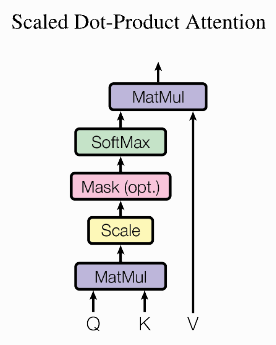

In [2]:
# define scaled-dot product 
def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / np.sqrt(d_k)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

It is always good to have some understanding of the input/output tensors dimensions:

In [3]:
input_len, d_k, d_v = 4, 3, 2
q = torch.randn(input_len, d_k)
k = torch.randn(input_len, d_k)
v = torch.randn(input_len, d_v)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Attention\n", attention)
print("Returned values\n", values)

Q
 tensor([[-0.0420,  0.6839, -0.6204],
        [ 0.5725, -1.0469,  1.0708],
        [-0.6928,  1.4198, -1.2270],
        [-0.0568,  0.3860,  0.0214]])
K
 tensor([[ 0.3229, -0.7308, -0.3279],
        [-0.4568, -0.3207, -2.4470],
        [ 0.0800,  0.3299,  0.0183],
        [ 0.9441,  1.4528, -2.3826]])
V
 tensor([[-1.9496, -1.1638],
        [-0.6609,  1.9461],
        [ 1.5239,  0.0883],
        [-1.3240,  1.5444]])
Attention
 tensor([[0.1022, 0.2617, 0.1381, 0.4979],
        [0.5385, 0.0876, 0.3242, 0.0496],
        [0.0316, 0.2709, 0.0650, 0.6325],
        [0.2028, 0.2220, 0.2600, 0.3151]])
Returned values
 tensor([[-0.8211,  1.1715],
        [-0.6794, -0.3510],
        [-0.9790,  1.4731],
        [-0.5631,  0.7058]])


### Multi-Head Attention
Now define **Multi-Head Attention** block with multiple ($h$) scaled dot-product blocks (heads):
$\begin{split}\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V),
\end{split}\end{split}$

with 
$W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and
$W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$,
where
$D$ is the input dimensionality.

The above matrices ($W^{Q}$, $W^{K}$, $W^{V}$) transform (via linear layers) input $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$ to respective inputs ($Q$, $K$, $V$) of  scaled dot-product attention module.
$W^O$ defines extra linear layer that combines information from multiple heads. 
Also, note that, $D=d_{model}$.

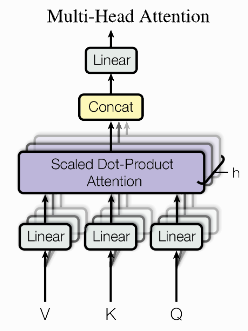

In [4]:
# define multi-head attention block
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        """
            Assumptions we made:
            d_k = d_v = head_dim
            num_heads*head_dim = embed_dim
            d_out = embed_dim
            D = d_model = input_dim 
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim) 
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x) # [batch_size, seq_length, 3*embed_dim]

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)  # [batch_size, seq_length, num_heads, 3*head_dim]
        qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, seq_length, 3*head_dim]
        q, k, v = qkv.chunk(3, dim=-1) # [batch_size, num_heads, seq_length, head_dim]

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3) # [batch_size, seq_length, num_heads, head_dim]
        values = values.reshape(batch_size, seq_length, self.embed_dim) # heads concatenation
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

Verify input/output tensors shape:

In [5]:
batch_size, input_len, input_dim, embed_dim, num_heads = 1, 4, 3, 4, 2
MHAtt = MultiheadAttention(input_dim, embed_dim, num_heads)
X = torch.randn(batch_size, input_len, input_dim)
values = MHAtt(X)
print("X\n", X.shape)
print("Returned values\n", values.shape)

X
 torch.Size([1, 4, 3])
Returned values
 torch.Size([1, 4, 4])


### Transformer Encoder
Now collect everything (attention + additional MLP + layer normalization + residual connections) into the encoder block, and combine encoder block into the whole **Transformer Encoder**:

In [6]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward):
        """
            input_dim - dimensionality of the input
            num_heads - number of heads to use in the attention block
            dim_feedforward - dimensionality of the hidden layer in the MLP
            For simplicity we assume input_dim = embed_dim
        """
        super().__init__()

        # Attention layer 
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.MLP_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x):
        # Attention part
        attn_out = self.self_attn(x)
        x = x + attn_out  # residual connection
        x = self.norm1(x)

        # MLP part
        linear_out = self.MLP_net(x)
        x = x + linear_out  # residual connection
        x = self.norm2(x)

        return x

class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional Encoding
**MHA** is by definintion sequence permutation-equivariant:

In [7]:
values = MHAtt(X)
print("X\n", X)
print("Returned values\n", values)
perm = torch.LongTensor([0,2,1,3])
X = X[:,perm,:]
values = MHAtt(X)
print("Permuted X\n", X)
print("Returned values\n", values)

X
 tensor([[[ 0.0956, -0.3191, -0.6848],
         [ 0.3558, -0.2439,  0.2695],
         [ 0.3203,  0.8332, -1.0127],
         [-0.4985, -0.0035, -1.0270]]])
Returned values
 tensor([[[-0.3321, -0.1740,  0.0214,  0.0169],
         [-0.3751, -0.1078, -0.0185, -0.0751],
         [-0.2855, -0.2156,  0.0671,  0.0739],
         [-0.2674, -0.2397,  0.0796,  0.1103]]], grad_fn=<ViewBackward0>)
Permuted X
 tensor([[[ 0.0956, -0.3191, -0.6848],
         [ 0.3203,  0.8332, -1.0127],
         [ 0.3558, -0.2439,  0.2695],
         [-0.4985, -0.0035, -1.0270]]])
Returned values
 tensor([[[-0.3321, -0.1740,  0.0214,  0.0169],
         [-0.2855, -0.2156,  0.0671,  0.0739],
         [-0.3751, -0.1078, -0.0185, -0.0751],
         [-0.2674, -0.2397,  0.0796,  0.1103]]], grad_fn=<ViewBackward0>)


To include positional realtions in the input sequence to the model we add some **Positional Encoding**

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
            d_model - input dim
            max_len - maximum length of a sequence to expect
            Encoding same as in the original paper
        """
        super().__init__()

        # create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

And visualise it

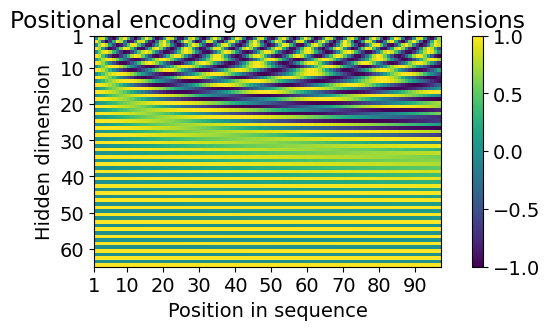

In [9]:
encod_block = PositionalEncoding(d_model=64, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

### Learning rate warm-up
Transformers also need a careful learning rate warm-up scheduling

In [10]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

Let's check how theLearning rate scheduling looks like 

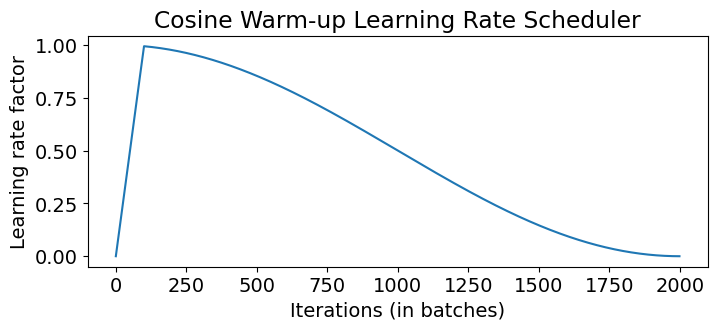

In [11]:
# dummy optimizer just for visualization
optimizer = optim.Adam([nn.Parameter(torch.empty(1,1))], lr=1.e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

epochs = list(range(2000))
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()

### Model definition
We are now ready to define the entire model, and also a few training utils



In [12]:
class TransformerModel(nn.Module):

    def __init__(self, input_dim, num_heads, num_layers):
        """
        Inputs:
            input_dim = model_dim - dimensionality to use inside the Transformer
            num_heads - number of heads to use in the Multi-Head Attention blocks
            num_layers - number of encoder blocks to use
            lr - learning rate in the optimizer
            warmup - number of warmup steps
            max_iters - number of maximum iterations the model is trained for
        """
        super().__init__()
        self.input_dim = input_dim 
        self.num_heads = num_heads
        self.num_layers = num_layers
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.input_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.input_dim,
                                              num_heads=self.num_heads,
                                              dim_feedforward=2*self.input_dim)

    def forward(self, x, add_positional_encoding=True):
        """
            x - input features of shape [Batch, SeqLen, input_dim]
        """
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x)
        return attention_maps


class TrainingUtils():

    def __init__(self, device, model, num_classes):
        self.model = model.to(device)
        self.num_classes = num_classes

    def define_optimizer(self, lr, warmup, max_iters):
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.lr_scheduler = CosineWarmupScheduler(optimizer, warmup=warmup, max_iters=max_iters)

    def _calculate_loss(self, batch):
        # get data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.num_classes).float().to(device)
        labels = labels.to(device)
        # perform prediction and calculate loss and accuracy
        preds = self.model(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        return loss, acc

    def _step(self, batch):
        loss, _ = self._calculate_loss(batch)
        return loss

    def train(self, train_loader, epoch_idx):
        self.model.train()
        train_loss = 0.
        # get subsequent batches over the data in a given epoch
        for batch_idx, batch in enumerate(train_loader):
            self.optimizer.zero_grad()
            loss = self._step(batch)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step(batch_idx + epoch_idx*len(train_loader))
            #print(self.lr_scheduler.get_last_lr())
            train_loss += loss.item()
        return train_loss/len(train_loader)

    def validate(self, val_loader, epoch_idx):
        self.model.eval()
        val_loss = 0.
        val_acc = 0.
        # get subsequent batches over the data in a given epoch
        for batch_idx, batch in enumerate(val_loader):
            loss, acc = self._calculate_loss(batch)
            val_loss  += loss.item()
            val_acc  += acc.item()
        return val_loss/len(val_loader), val_acc/len(val_loader)

    def plot_loss(self, train_losses, val_losses, title=None):
        plt.grid(True)
        plt.xlabel("subsequent epochs")
        plt.ylabel('loss')
        xlabels = np.linspace(0, model_args['epochs'], num=len(train_losses), endpoint=True)
        plt.plot(xlabels, train_losses, label='training')
        plt.plot(xlabels, val_losses, label='validation')
        plt.legend()
        if title is not None: plt.title(title)
        plt.show()



Now perform some experiments

## Experiments
We are going to use transformer model to translate between some sequences
- in first task the goal is to flip random sequences of numbers between 0 and 9
- the second task will be to sort random sequences of numbers between 0 and 9

In [26]:
model_args = {}
model_args['batch_size'] = 128

# learning rate is how fast it will descend
model_args['lr'] = 1.e-3
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 20

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [14]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

Now generate dataset

In [25]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=model_args['batch_size'], 
                               shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(5000), batch_size=model_args['batch_size'])
test_loader  = data.DataLoader(dataset(10000), batch_size=model_args['batch_size'])

inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([2, 1, 4, 0, 0, 8, 3, 7, 0, 6, 1, 1, 1, 2, 1, 9])
Labels:     tensor([9, 1, 2, 1, 1, 1, 6, 0, 7, 3, 8, 0, 0, 4, 1, 2])


Define model and training utils

In [38]:
model = TransformerModel(input_dim=train_loader.dataset.num_categories, 
                         num_heads=1,
                         num_layers=1).to(device)
summary(model, input_size=(16,10))

utils = TrainingUtils(device=device, 
                      model=model, 
                      num_classes=train_loader.dataset.num_categories) 
utils.define_optimizer(lr=model_args['lr'], 
                       warmup=500, 
                       max_iters=model_args['epochs']*len(train_loader))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
PositionalEncoding-1               [-1, 16, 10]               0
            Linear-2               [-1, 16, 30]             330
            Linear-3               [-1, 16, 10]             110
MultiheadAttention-4               [-1, 16, 10]               0
         LayerNorm-5               [-1, 16, 10]              20
            Linear-6               [-1, 16, 20]             220
              ReLU-7               [-1, 16, 20]               0
            Linear-8               [-1, 16, 10]             210
         LayerNorm-9               [-1, 16, 10]              20
     EncoderBlock-10               [-1, 16, 10]               0
TransformerEncoder-11               [-1, 16, 10]               0
Total params: 910
Trainable params: 910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backwar

Finally, let's perform training

Train Epoch 1 | training loss = 2.4805 | validation loss = 2.3664 | validation acc 0.1071
Train Epoch 2 | training loss = 2.2933 | validation loss = 2.1367 | validation acc 0.2286
Train Epoch 3 | training loss = 1.5473 | validation loss = 1.1553 | validation acc 0.6699
Train Epoch 4 | training loss = 1.0857 | validation loss = 1.0406 | validation acc 0.6971
Train Epoch 5 | training loss = 1.0076 | validation loss = 0.9819 | validation acc 0.7078
Train Epoch 6 | training loss = 0.9546 | validation loss = 0.9370 | validation acc 0.7136
Train Epoch 7 | training loss = 0.9091 | validation loss = 0.8915 | validation acc 0.7206
Train Epoch 8 | training loss = 0.8681 | validation loss = 0.8535 | validation acc 0.7278
Train Epoch 9 | training loss = 0.8339 | validation loss = 0.8224 | validation acc 0.7342
Train Epoch 10 | training loss = 0.8051 | validation loss = 0.7970 | validation acc 0.7408
Train Epoch 11 | training loss = 0.7800 | validation loss = 0.7724 | validation acc 0.7449
Train Ep

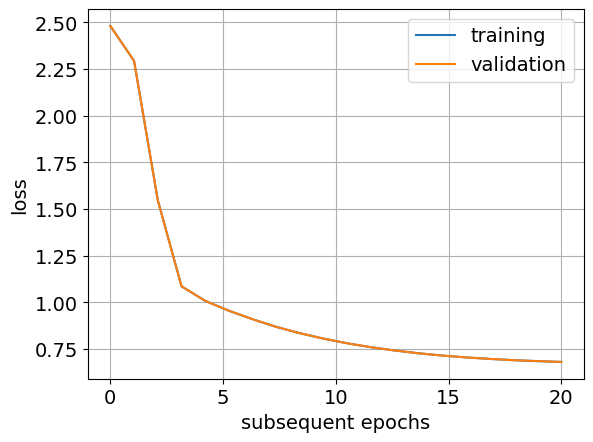

In [39]:
train_losses = []
validation_losses = []
for epoch_idx in range(model_args['epochs']):
    train_loss = utils.train(train_loader, epoch_idx)
    val_loss, val_acc = utils.validate(val_loader, epoch_idx)
    print('Train Epoch {} | training loss = {:.4f} | validation loss = {:.4f} | validation acc {:.4f}'.
          format(epoch_idx+1, train_loss, val_loss, val_acc))
    train_losses.append(train_loss)

utils.plot_loss(train_losses, train_losses)

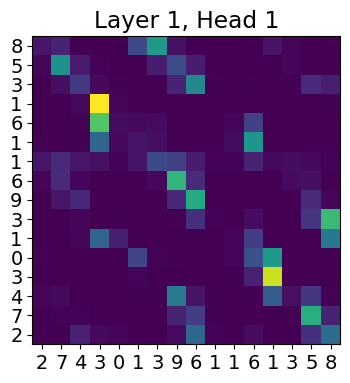

In [40]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

model.eval()
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=val_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)
plot_attention_maps(data_input, attention_maps, idx=0)

## Tasks to do
* try to optimize the model hyperparameters (e.g. no of layers, no of heads within the layers), **it may be necessary to restart training several times**;
* please play with different ingrediends of the Transformer model, e.g. turn-off positional encoding, or residual connections in the *EncoderBlock*, or use standard *lr_scheduler* (i.e. without warming-up);
* please change the problem to learning a dataset with 0-9 digits in random order that we want to translate to sorted series (i.e. train the Transformer to learn sorting) -- please plot the attension map in that case -- do we have any understanding of this?